In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 

In [2]:
IMG_HEIGHT = IMG_WIDTH = 224 

# Get the Data 

In [3]:
train_set = pd.read_csv("../datasets/data_support/train.csv", index_col=0)
dev_set = pd.read_csv("../datasets/data_support/validation.csv", index_col=0) 
test_set = pd.read_csv("../datasets/data_support/test.csv", index_col=0)  

In [4]:
train_set.head() 

,paths,chiffon,conventional,cotton,crew_neckline,denim,embroidered,faux,floral,graphic,...,no_dress,no_neckline,pleated,short_sleeve,sleeveless,solid,square_neckline,striped,tight,v_neckline
0,../datasets/big_ds/img-001/img/Vented_Back_Tan...,0,1.0,1,1,0,0,0,0,0,...,1.0,0.0,0,0.0,1,1,0.0,0,0,0
1,../datasets/big_ds/img-001/img/Hooded_Woven_Ja...,0,1.0,0,1,0,0,1,0,0,...,1.0,0.0,0,0.0,0,1,0.0,0,0,0
2,../datasets/big_ds/img-001/img/Strapless_Sweet...,1,1.0,0,0,0,1,0,0,0,...,0.0,1.0,0,0.0,1,0,0.0,0,0,0
3,../datasets/big_ds/img-001/img/Acid_Washed_Den...,0,1.0,0,0,1,0,0,1,0,...,1.0,1.0,0,0.0,1,0,0.0,0,0,0
4,../datasets/big_ds/img-001/img/Trust_Nobody_Mu...,0,1.0,1,1,0,0,0,0,1,...,1.0,0.0,0,0.0,1,0,0.0,0,0,0


In [5]:
train_set.shape, dev_set.shape, test_set.shape

((278022, 27), (5600, 27), (5600, 27))

# 2. Preprocessing Dataset 
- Train set includes None values. 
- Replace them with -1 to do sample weighting. 

In [6]:
train_set[train_set.columns[1:]] = train_set[train_set.columns[1:]].fillna(-1)

In [7]:
np.unique(train_set.iloc[:,1:].values.flatten()), np.unique(test_set.iloc[:,1:].values.flatten()), np.unique(dev_set.iloc[:,1:].values.flatten()), 

(array([-1.,  0.,  1.]),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

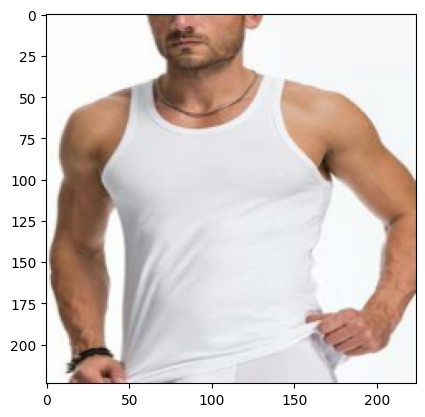

chiffon              0
conventional       1.0
cotton               1
crew_neckline        1
denim                0
embroidered          0
faux                 0
floral               0
graphic              0
knit                 0
lattice              0
leather              0
long_sleeve          0
loose                0
maxi_length          0
mini_length          0
no_dress           1.0
no_neckline        0.0
pleated              0
short_sleeve       0.0
sleeveless           1
solid                1
square_neckline    0.0
striped              0
tight                0
v_neckline           0
Name: 100, dtype: object

In [9]:
from helpers import show_image
show_image(train_set.iat[100,0])
train_set.iloc[100, 1:]

In [10]:
for col in train_set.columns[1:]:
    train_set[col] = train_set[col].astype("int") 

In [11]:
train_set.dtypes

paths              object
chiffon             int32
conventional        int32
cotton              int32
crew_neckline       int32
denim               int32
embroidered         int32
faux                int32
floral              int32
graphic             int32
knit                int32
lattice             int32
leather             int32
long_sleeve         int32
loose               int32
maxi_length         int32
mini_length         int32
no_dress            int32
no_neckline         int32
pleated             int32
short_sleeve        int32
sleeveless          int32
solid               int32
square_neckline     int32
striped             int32
tight               int32
v_neckline          int32
dtype: object

# 3. Train and Train-Dev Set Split 

- Train Set 
- Train Dev Set 
- Dev Set 
- Test Set 

In [12]:
from sklearn.model_selection import train_test_split 
train_set.shape 

(278022, 27)

In [13]:
X_train, X_train_dev, y_train, y_train_dev = train_test_split(train_set.iloc[:, 0], train_set.iloc[:, 1:], test_size=0.05, random_state=47) 

In [14]:
X_train.shape, X_train_dev.shape 

((264120,), (13902,))

In [15]:
train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True) 
train_dev_set = pd.concat([X_train_dev, y_train_dev], axis=1).reset_index(drop=True) 

# 4. Keras Data Generators 

In [16]:
X_train = train_set.iloc[:, 0] 
y_train = train_set.iloc[:, 1:]

X_train_dev = train_dev_set.iloc[:, 0] 
y_train_dev = train_dev_set.iloc[:, 1:] 

X_dev = dev_set.iloc[:, 0] 
y_dev = dev_set.iloc[:, 1:]

X_test = test_set.iloc[:, 0] 
y_test = test_set.iloc[:, 1:] 

In [17]:
merged_all_classes = [] 
for idx, row in y_train.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_train = pd.Series(merged_all_classes, index=y_train.index, name="labels") 

merged_all_classes = [] 
for idx, row in y_train_dev.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_train_dev = pd.Series(merged_all_classes, index=y_train_dev.index, name="labels") 

merged_all_classes = [] 
for idx, row in y_dev.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_dev = pd.Series(merged_all_classes, index=y_dev.index, name="labels") 


merged_all_classes = [] 
for idx, row in y_test.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_test = pd.Series(merged_all_classes, index=y_test.index, name="labels") 

In [18]:
train_data_flow_df = pd.concat([
    X_train, 
    y_train
], axis=1)

train_dev_data_flow_df = pd.concat([
    X_train_dev, 
    y_train_dev
], axis=1)

dev_data_flow_df = pd.concat([
    X_dev, 
    y_dev
], axis=1)

test_data_flow_df = pd.concat([
    X_test, 
    y_test
], axis=1) 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_gen = ImageDataGenerator() # train set 
train_dev_gen = ImageDataGenerator() # train dev set 
dev_gen = ImageDataGenerator()  # dev set 
test_gen = ImageDataGenerator() # test set 

In [20]:
train = train_gen.flow_from_dataframe(
    dataframe=train_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    class_mode='categorical', 
    target_size=(IMG_HEIGHT, IMG_WIDTH))

train_dev = train_dev_gen.flow_from_dataframe(
    dataframe=train_dev_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    class_mode='categorical', 
    target_size=(IMG_HEIGHT, IMG_WIDTH))

dev = dev_gen.flow_from_dataframe(
    dataframe=dev_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    class_mode='categorical', 
    target_size=(IMG_HEIGHT, IMG_WIDTH))

test = test_gen.flow_from_dataframe(
    dataframe=test_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    class_mode='categorical', 
    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 264120 validated image filenames belonging to 26 classes.
Found 13902 validated image filenames belonging to 26 classes.
Found 5600 validated image filenames belonging to 26 classes.
Found 5600 validated image filenames belonging to 26 classes.


# 5. Model Building 

## Model 1: Backbone Efficient Net B0

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [22]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

In [23]:
inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 
x = base_model(inputs) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs = tf.keras.layers.Dense(train_set.shape[1] -1, 
                                activation=tf.keras.activations.sigmoid,
                                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
model_1 = tf.keras.Model(inputs, outputs) 

In [24]:
from tensorflow.keras import backend as K 

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [25]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=masked_loss_function,
              metrics=METRICS)

In [27]:
checkpoint_path = "checkpoints/ADDING_MORE_DATA/Model_1d/checkpoint-{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

history_model_1 = model_1.fit(
        train, 
        validation_data=train_dev,
        epochs=10,
        callbacks=[checkpoint_callback])

Epoch 1/10
8254/8254 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9732 - precision: 0.9039 - recall: 0.6326
Epoch 1: saving model to checkpoints/ADDING_MORE_DATA/Model_1d\checkpoint-1.ckpt
8254/8254 [==============================] - 11857s 1s/step - loss: 0.0932 - accuracy: 0.9732 - precision: 0.9039 - recall: 0.6326 - val_loss: 0.7674 - val_accuracy: 0.7912 - val_precision: 0.7551 - val_recall: 0.1407
Epoch 2/10
8254/8254 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9733 - precision: 0.9037 - recall: 0.6332
Epoch 2: saving model to checkpoints/ADDING_MORE_DATA/Model_1d\checkpoint-2.ckpt
8254/8254 [==============================] - 10580s 1s/step - loss: 0.0930 - accuracy: 0.9733 - precision: 0.9037 - recall: 0.6332 - val_loss: 0.8114 - val_accuracy: 0.7914 - val_precision: 0.7611 - val_recall: 0.1403
Epoch 3/10
8254/8254 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9733 - precision: 0.9038 - recall: 0.63